In [1]:
import re
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
##전역 변수
vocab_size = 4000
max_len = 70
tag_size = 10
word_len = 25
char_size = 59
chars_len = 300

## 파일을 읽고 

In [3]:
def readfile(filename):
    f = open(filename, 'r')
    tagged_sentences = []
    sentence = []

    for line in f:
        if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
            if len(sentence) > 0:
                tagged_sentences.append(sentence)
                sentence = []
            continue
        splits = line.split(' ') # 공백을 기준으로 속성을 구분한다.
        splits[-1] = re.sub(r'\n', '', splits[-1]) # 줄바꿈 표시 \n을 제거한다.
        #word = splits[0].lower() # 단어들은 소문자로 바꿔서 저장한다.
        sentence.append([splits[0], splits[-1]]) # 단어와 개체명 태깅만 기록한다.
    return tagged_sentences

In [4]:
trainSentences=readfile("train.txt")

In [5]:
validSentences=readfile("valid.txt")
testSentences=readfile("test.txt")

In [6]:
def seperatearray(rawsentence):
    sentences, ner_tags = [], [] 
    for tagged_sentence in rawsentence: # 14,041개의 문장 샘플을 1개씩 불러온다.
        sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
        sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
        ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.
    return sentences, ner_tags

In [7]:
train_sentence, train_tag = seperatearray(trainSentences)
valid_sentence, valid_tag = seperatearray(validSentences)
test_sentence, test_tag = seperatearray(testSentences)

In [8]:
train_sentence[:3]

[['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'],
 ['Peter', 'Blackburn'],
 ['BRUSSELS', '1996-08-22']]

In [9]:
def addCharInformation(Sentences):
    ans=[]
    for i,sentence in enumerate(Sentences):
        newSentence=[]
        
        for j,data in enumerate(sentence):
            wrd=[]
            for k,ch in enumerate(data):
                # print(ch.split(','))
                wrd.extend(ch.split(','))
            newSentence.extend(wrd)
            # newSentence.append(wrd) # 단어, Chracter, NER을 리스트로
        ans.append(newSentence)
    return ans

In [10]:
train_char = addCharInformation(train_sentence)
valid_char = addCharInformation(valid_sentence)
test_char = addCharInformation(test_sentence)

In [11]:
train_char[:3]

[['E',
  'U',
  'r',
  'e',
  'j',
  'e',
  'c',
  't',
  's',
  'G',
  'e',
  'r',
  'm',
  'a',
  'n',
  'c',
  'a',
  'l',
  'l',
  't',
  'o',
  'b',
  'o',
  'y',
  'c',
  'o',
  't',
  't',
  'B',
  'r',
  'i',
  't',
  'i',
  's',
  'h',
  'l',
  'a',
  'm',
  'b',
  '.'],
 ['P', 'e', 't', 'e', 'r', 'B', 'l', 'a', 'c', 'k', 'b', 'u', 'r', 'n'],
 ['B',
  'R',
  'U',
  'S',
  'S',
  'E',
  'L',
  'S',
  '1',
  '9',
  '9',
  '6',
  '-',
  '0',
  '8',
  '-',
  '2',
  '2']]

In [12]:
max_len = max([len(i) for i in train_char])
print(max_len)

427


샘플의 최대 길이 : 427
샘플의 평균 길이 : 63.967595


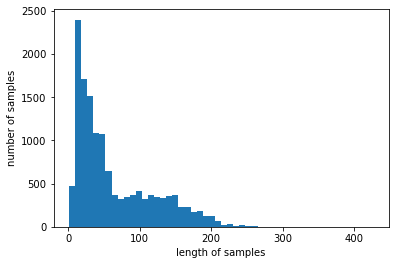

In [13]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in train_char))
print('샘플의 평균 길이 : %f' % (sum(map(len, train_char))/len(train_char)))
plt.hist([len(s) for s in train_char], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [14]:
char_tokenizer = Tokenizer()         #tokenizer 객체 생성
char_tokenizer.fit_on_texts(train_char)  

In [15]:
char_size =len(char_tokenizer.word_index) + 1
print('문자 집합의 크기 : {}'.format(char_size))

문자 집합의 크기 : 59


In [16]:
X_char_train = char_tokenizer.texts_to_sequences(train_char)
X_char_valid = char_tokenizer.texts_to_sequences(valid_char)
X_char_test = char_tokenizer.texts_to_sequences(test_char)

In [17]:
X_char_train[:3]

[[1,
  13,
  8,
  1,
  38,
  1,
  12,
  3,
  7,
  17,
  1,
  8,
  14,
  2,
  4,
  12,
  2,
  9,
  9,
  3,
  6,
  20,
  6,
  21,
  12,
  6,
  3,
  3,
  20,
  8,
  5,
  3,
  5,
  7,
  11,
  9,
  2,
  14,
  20,
  22],
 [15, 1, 3, 1, 8, 20, 9, 2, 12, 26, 20, 13, 8, 4],
 [20, 8, 13, 7, 7, 1, 9, 7, 24, 29, 29, 30, 23, 27, 34, 23, 28, 28]]

In [18]:
index_to_char = char_tokenizer.index_word
index_to_char

{1: 'e',
 2: 'a',
 3: 't',
 4: 'n',
 5: 'i',
 6: 'o',
 7: 's',
 8: 'r',
 9: 'l',
 10: 'd',
 11: 'h',
 12: 'c',
 13: 'u',
 14: 'm',
 15: 'p',
 16: 'f',
 17: 'g',
 18: '',
 19: 'w',
 20: 'b',
 21: 'y',
 22: '.',
 23: '-',
 24: '1',
 25: 'v',
 26: 'k',
 27: '0',
 28: '2',
 29: '9',
 30: '6',
 31: '3',
 32: '5',
 33: '4',
 34: '8',
 35: '(',
 36: ')',
 37: '7',
 38: 'j',
 39: '"',
 40: "'",
 41: 'x',
 42: 'z',
 43: 'q',
 44: ':',
 45: '/',
 46: '$',
 47: '+',
 48: '*',
 49: ';',
 50: '&',
 51: '%',
 52: '=',
 53: '?',
 54: '[',
 55: ']',
 56: '`',
 57: '!',
 58: '@'}

In [19]:
X_char_train = pad_sequences(X_char_train, padding='post',maxlen=chars_len)
X_char_valid = pad_sequences(X_char_valid, padding='post',maxlen=chars_len)
X_char_test = pad_sequences(X_char_test, padding='post',maxlen=chars_len)

In [20]:
X_char_train[0]

array([ 1, 13,  8,  1, 38,  1, 12,  3,  7, 17,  1,  8, 14,  2,  4, 12,  2,
        9,  9,  3,  6, 20,  6, 21, 12,  6,  3,  3, 20,  8,  5,  3,  5,  7,
       11,  9,  2, 14, 20, 22,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [21]:
max_words = 4000        #문장 데이터에 있는 모든 단어를 사용하지 않고 높은 빈도수를 가진 상위 약 4,000개의 단어만을 사용
src_tokenizer = Tokenizer(num_words=max_words, oov_token='OOV')         #tokenizer 객체 생성
src_tokenizer.fit_on_texts(train_sentence)                              #인덱스 구축 

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(train_tag)

In [22]:
tar_tokenizer

In [23]:
vocab_size = max_words
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 4000
개체명 태깅 정보 집합의 크기 : 10


In [24]:
X_train = src_tokenizer.texts_to_sequences(train_sentence)
y_train = tar_tokenizer.texts_to_sequences(train_tag)

In [25]:
print(train_sentence[:3])

[['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], ['Peter', 'Blackburn'], ['BRUSSELS', '1996-08-22']]


In [26]:
X_valid = src_tokenizer.texts_to_sequences(valid_sentence)
y_valid = tar_tokenizer.texts_to_sequences(valid_tag)

X_test = src_tokenizer.texts_to_sequences(test_sentence)
y_test = tar_tokenizer.texts_to_sequences(test_tag)

In [27]:
X_train[:3]

[[989, 1, 205, 629, 7, 3939, 216, 1, 3], [774, 1872], [726, 150]]

In [28]:
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word


In [29]:
index_to_ner

{1: 'o',
 2: 'b-loc',
 3: 'b-per',
 4: 'b-org',
 5: 'i-per',
 6: 'i-org',
 7: 'b-misc',
 8: 'i-loc',
 9: 'i-misc'}

In [30]:
decoded = []
for index in X_test[0] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존 문장 : {}'.format(test_sentence[0]))
print('빈도수가 낮은 단어가 OOV 처리된 문장 : {}'.format(decoded))

기존 문장 : ['SOCCER', '-', 'JAPAN', 'GET', 'LUCKY', 'WIN', ',', 'CHINA', 'IN', 'SURPRISE', 'DEFEAT', '.']
빈도수가 낮은 단어가 OOV 처리된 문장 : ['soccer', '-', 'japan', 'get', 'OOV', 'win', ',', 'china', 'in', 'surprise', 'defeat', '.']


In [31]:
max_len = 70
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
# X_train의 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.
y_train = pad_sequences(y_train, padding='post', maxlen=max_len+)
# y_train의 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자0으로 채움.
X_valid = pad_sequences(X_valid, padding='post', maxlen=max_len)
y_valid = pad_sequences(y_valid, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)
y_test = pad_sequences(y_test, padding='post', maxlen=max_len)

In [32]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_valid = to_categorical(y_valid, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)           ##원핫 인코딩 시킴 

In [44]:
y_train.shape

(14041, 70, 10)

In [34]:
X_char_train.shape

(14041, 300)

In [35]:
X_final_train = tf.concat([X_train,X_char_train],axis=-1)
X_final_valid = tf.concat([X_valid,X_char_valid],axis=-1)
X_final_test = tf.concat([X_test,X_char_test],axis=-1)

In [36]:
X_final_train.shape

TensorShape([14041, 370])

# ==================<< 모델 생성 >>================

In [40]:
class TestModel (tf.keras.Model):
    def __init__(self,vocab_size,char_size,tag_size):
        super().__init__()
        self.fEmbedding = tf.keras.layers.Embedding(input_dim=vocab_size+char_size, output_dim=128, mask_zero=True)
        self.fBiLSTM = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True), merge_mode='concat')
        self.fTimeDistributed = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(tag_size, activation='softmax'))

    def call(self, x):
        x = self.fEmbedding(x)
        x = self.fBiLSTM(x)
       
        x = self.fTimeDistributed(x)
        return x


In [41]:
modelSub = TestModel(vocab_size,char_size,tag_size)
subClassInputs = tf.keras.layers.Input(shape=(370, ),dtype='int32')
subClassInputs

<tf.Tensor 'input_2:0' shape=(None, 370) dtype=int32>

In [42]:
modelSub(subClassInputs)
modelSub.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
modelSub.summary()

Model: "test_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 370, 128)          519552    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 370, 512)          788480    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 370, 10)           5130      
Total params: 1,313,162
Trainable params: 1,313,162
Non-trainable params: 0
_________________________________________________________________


In [43]:
modelSub.fit(X_final_train, y_train, batch_size=128, epochs=8,  validation_data=(X_final_test, y_test))

Train on 14041 samples, validate on 3453 samples
Epoch 1/8
  128/14041 [..............................] - ETA: 3:27

ValueError: Dimensions must be equal, but are 70 and 370 for 'loss/output_1_loss/mul' (op: 'Mul') with input shapes: [?,70,10], [?,370,10].

In [ ]:
words_input = tf.keras.layers.Input(shape=(None, ),dtype='int32', name='modelInput')
words = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128, mask_zero=True)(words_input)

In [ ]:
character_input=tf.keras.layers.Input(shape=(None,),name='char_input')
embed_char_out=tf.keras.layers.Embedding(char_size,30,embeddings_initializer=tf.keras.initializers.RandomUniform(minval=-0.5, maxval=0.5))(character_input)

In [ ]:

dropout= tf.keras.layers.Dropout(0.5)(embed_char_out)
conv1d_out=tf.keras.layers.Conv1D(kernel_size=3, filters=30, padding='same',activation='tanh', strides=1)(dropout)
maxpool_out=tf.keras.layers.MaxPooling1D(char_size)(conv1d_out)

char = tf.keras.layers.Dropout(0.5)(maxpool_out)

In [ ]:
output = tf.keras.layers.concatenate([words, char])
output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True, dropout=0.50, recurrent_dropout=0.25))(output)
output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10, activation='softmax'))(output)

In [ ]:
model = tf.keras.Model(inputs=[words_input, character_input], outputs=[output])
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam')
model.summary()

In [ ]:
model.fit(x=[X_train, X_char_train],y=y_train,epochs=8,batch_size=128,validation_data=([X_valid, X_char_valid], y_valid))

In [ ]:
modelCNN = tf.keras.Model(inputs=character_input, outputs=char)

In [ ]:
modelCNN.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [ ]:
modelCNN.summary()

In [ ]:
fit(X_train, y_train, batch_size=128, epochs=8,  validation_data=(X_test, y_test))

# =======================================================================
# 모델 3. Subclaissing Model 
### - many2many bidirectional LSTM with TimeDistributed 
### - Subclaissing

In [ ]:
class TestModel (tf.keras.Model):
    def __init__(self,vocab_size,tag_size):
        super().__init__()
        self.fEmbedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128, mask_zero=True)
        self.fBiLSTM = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True), merge_mode='concat')
        # self.fBiLSTM_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True), merge_mode='concat')
        # self.fDense = (tf.keras.layers.Dense(128, activation='softmax'))
        self.fTimeDistributed = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(tag_size, activation='softmax'))

    def call(self, x):
        x = self.fEmbedding(x)
        x = self.fBiLSTM(x)
        # x = self.fDense(x)
        # x = self.fBiLSTM(x)
        x = self.fTimeDistributed(x)
        return x


In [ ]:
modelSub = TestModel(4000,10)
subClassInputs = tf.keras.layers.Input(shape=(70, ),dtype='int32')
subClassInputs

In [ ]:
modelSub(subClassInputs)
modelSub.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
modelSub.summary()

In [ ]:
modelSub.fit(X_train, y_train, batch_size=128, epochs=8,  validation_data=(X_test, y_test))

In [ ]:
print("\n 테스트 정확도: %.4f" % (modelSub.evaluate(X_test, y_test,verbose=0)[1]))

# ========================================================================================
# 모델 2. CNN을 추가한 모델

In [ ]:
i=10 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t].upper(), index_to_ner[pred].upper()))